In [ ]:
# Análise de Ganho de Informação - Dataset SVM KubeMon

Este notebook calcula o ganho de informação para todas as features do dataset SVM, ajudando a identificar as métricas mais importantes para a classificação de anomalias no sistema Kubernetes.

In [2]:
# Importar bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("Bibliotecas importadas com sucesso!")
print("Pronto para calcular o ganho de informação do dataset SVM")

Bibliotecas importadas com sucesso!
Pronto para calcular o ganho de informação do dataset SVM


## 1. Carregamento do Dataset

In [23]:
# Carregar o dataset SVM
caminho_arquivo = r"svm.csv"

print("Carregando o dataset SVM...")
try:
    # Tentar carregar o arquivo completo
    df = pd.read_csv(caminho_arquivo)
    print(f"Dataset carregado com sucesso! Shape: {df.shape}")
    
except Exception as e:
    print(f"Erro ao carregar o dataset completo: {e}")
    print("Tentando carregar uma amostra...")
    # Se o arquivo for muito grande, carregar uma amostra
    df = pd.read_csv(caminho_arquivo, nrows=50000)
    print(f"Amostra carregada: {df.shape[0]} linhas")

# Informações básicas do dataset
print(f"\nInformações do dataset:")
print(f"- Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"- Colunas: {list(df.columns)[:10]}..." if len(df.columns) > 10 else f"- Colunas: {list(df.columns)}")

# Verificar se a coluna target existe
target_column = 'target'


Carregando o dataset SVM...
Dataset carregado com sucesso! Shape: (80648, 126)

Informações do dataset:
- Dimensões: 80648 linhas x 126 colunas
- Colunas: ['mean_os_cpu_ctx_switches', 'mean_os_cpu_guest', 'mean_os_cpu_guest_nice', 'mean_os_cpu_idle', 'mean_os_cpu_interrupts', 'mean_os_cpu_iowait', 'mean_os_cpu_irq', 'mean_os_cpu_nice', 'mean_os_cpu_soft_interrupts', 'mean_os_cpu_softirq']...


In [12]:
#df['node_name'] = df['node_name'].astype('category').cat.codes
df['node_name'] 

0        node1-5
1        node1-5
2        node1-5
3        node1-5
4        node1-5
          ...   
80643      node4
80644      node4
80645      node4
80646      node3
80647      node4
Name: node_name, Length: 80648, dtype: object

## 2. Pré-processamento dos Dados

In [17]:
# Pré-processamento dos dados para cálculo do ganho de informação
if target_column is not None:
    print("=== PRÉ-PROCESSAMENTO ===")
    
    # Separar features e target
    # Excluir colunas não numéricas e de identificação
    colunas_excluir = ['os_timestamp', 'node_name', 'iteration', target_column]
    colunas_excluir = [col for col in colunas_excluir if col in df.columns]
    
    # Selecionar apenas colunas numéricas para features
    features = df.select_dtypes(include=[np.number]).columns.tolist()
    features = [col for col in features if col not in colunas_excluir]
    
    print(f"Total de features numéricas: {len(features)}")
    print(f"Colunas excluídas: {colunas_excluir}")
    
    # Preparar dados
    X = df[features].copy()
    y = df[target_column].copy()
    
    # Verificar valores ausentes
    valores_ausentes = X.isnull().sum()
    if valores_ausentes.sum() > 0:
        print(f"Valores ausentes encontrados em {valores_ausentes[valores_ausentes > 0].shape[0]} colunas")
        # Preencher valores ausentes com a mediana
        X = X.fillna(X.median())
        print("Valores ausentes preenchidos com a mediana")
    
    # Codificar target se for string
    le = LabelEncoder()
    if y.dtype == 'object':
        y_encoded = le.fit_transform(y)
        print(f"Target codificado: {dict(zip(le.classes_, le.transform(le.classes_)))}")
    else:
        y_encoded = y.values
    
    print(f"Shape final dos dados: X={X.shape}, y={len(y_encoded)}")
    print(f"Classes na variável target: {np.unique(y_encoded, return_counts=True)}")
    
else:
    print("❌ Não é possível calcular ganho de informação sem coluna target")

=== PRÉ-PROCESSAMENTO ===
Total de features numéricas: 122
Colunas excluídas: ['os_timestamp', 'node_name', 'iteration', 'target']
Target codificado: {'interf': np.int64(0), 'normal': np.int64(1)}
Shape final dos dados: X=(80648, 122), y=80648
Classes na variável target: (array([0, 1]), array([45660, 34988]))


## 3. Implementação do Cálculo de Ganho de Informação

In [14]:
# Funções para calcular ganho de informação
def calcular_entropia(y):
    """Calcula a entropia de uma variável categórica"""
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    return entropy(probabilities, base=2)

def discretizar_feature(feature, n_bins=10):
    """Discretiza uma feature contínua em bins"""
    return pd.cut(feature, bins=n_bins, duplicates='drop', labels=False)

def calcular_ganho_informacao_manual(X_feature, y):
    """Calcula ganho de informação manualmente"""
    # Entropia inicial do target
    entropia_inicial = calcular_entropia(y)
    
    # Discretizar a feature se for contínua
    if len(np.unique(X_feature)) > 20:  # Se tem mais de 20 valores únicos
        X_discretizada = discretizar_feature(X_feature)
    else:
        X_discretizada = X_feature
    
    # Remover valores NaN
    mask = ~pd.isna(X_discretizada)
    X_discretizada = X_discretizada[mask]
    y_filtrado = y[mask]
    
    if len(X_discretizada) == 0:
        return 0
    
    # Calcular entropia condicional
    valores_unicos, counts = np.unique(X_discretizada, return_counts=True)
    entropia_condicional = 0
    
    for valor, count in zip(valores_unicos, counts):
        if count > 0:
            y_subset = y_filtrado[X_discretizada == valor]
            prob = count / len(X_discretizada)
            entropia_subset = calcular_entropia(y_subset)
            entropia_condicional += prob * entropia_subset
    
    # Ganho de informação = Entropia inicial - Entropia condicional
    ganho = entropia_inicial - entropia_condicional
    return max(0, ganho)  # Garantir que não seja negativo

print("Funções de cálculo de ganho de informação implementadas!")

Funções de cálculo de ganho de informação implementadas!


## 4. Cálculo do Ganho de Informação para Todas as Features

In [25]:
# Calcular ganho de informação para todas as features
if target_column is not None:
    print("=== CALCULANDO GANHO DE INFORMAÇÃO ===")
    print(f"Calculando para {len(features)} features...")
    
    # Método 1: Usando sklearn (Informação Mútua)
    print("\n1. Usando Informação Mútua (sklearn)...")
    try:
        # Para features contínuas, usar mutual_info_classif
        mi_scores = mutual_info_classif(X, y_encoded, random_state=42)
        
        # Criar DataFrame com os resultados
        resultados_mi = pd.DataFrame({
            'feature': features,
            'mutual_info': mi_scores
        }).sort_values('mutual_info', ascending=False)
        
        print("✅ Informação Mútua calculada com sucesso!")
        
    except Exception as e:
        print(f"❌ Erro no cálculo de informação mútua: {e}")
        resultados_mi = None
    
 

=== CALCULANDO GANHO DE INFORMAÇÃO ===
Calculando para 122 features...

1. Usando Informação Mútua (sklearn)...
✅ Informação Mútua calculada com sucesso!
✅ Informação Mútua calculada com sucesso!


## 5. Análise e Visualização dos Resultados

=== RESULTADOS DO GANHO DE INFORMAÇÃO ===

🏆 TOP 20 FEATURES - INFORMAÇÃO MÚTUA:
 1. mean_os_net_bytes_sent                             | MI: 0.656843
 2. mean_os_net_num_connections                        | MI: 0.530587
 3. mean_process_cpu_system                            | MI: 0.410629
 4. mean_process_disk_write_bytes                      | MI: 0.393318
 5. mean_process_disk_read_count                       | MI: 0.381996
 6. mean_process_cpu_user                              | MI: 0.364623
 7. mean_process_disk_write_count                      | MI: 0.353629
 8. mean_process_disk_read_chars                       | MI: 0.328693
 9. mean_os_net_packets_sent                           | MI: 0.287523
10. mean_process_disk_write_chars                      | MI: 0.270808
11. mean_os_net_bytes_recv                             | MI: 0.269238
12. mean_process_net_rx_bytes                          | MI: 0.237572
13. mean_container_mem_cache                           | MI: 0.234539
14. mean_

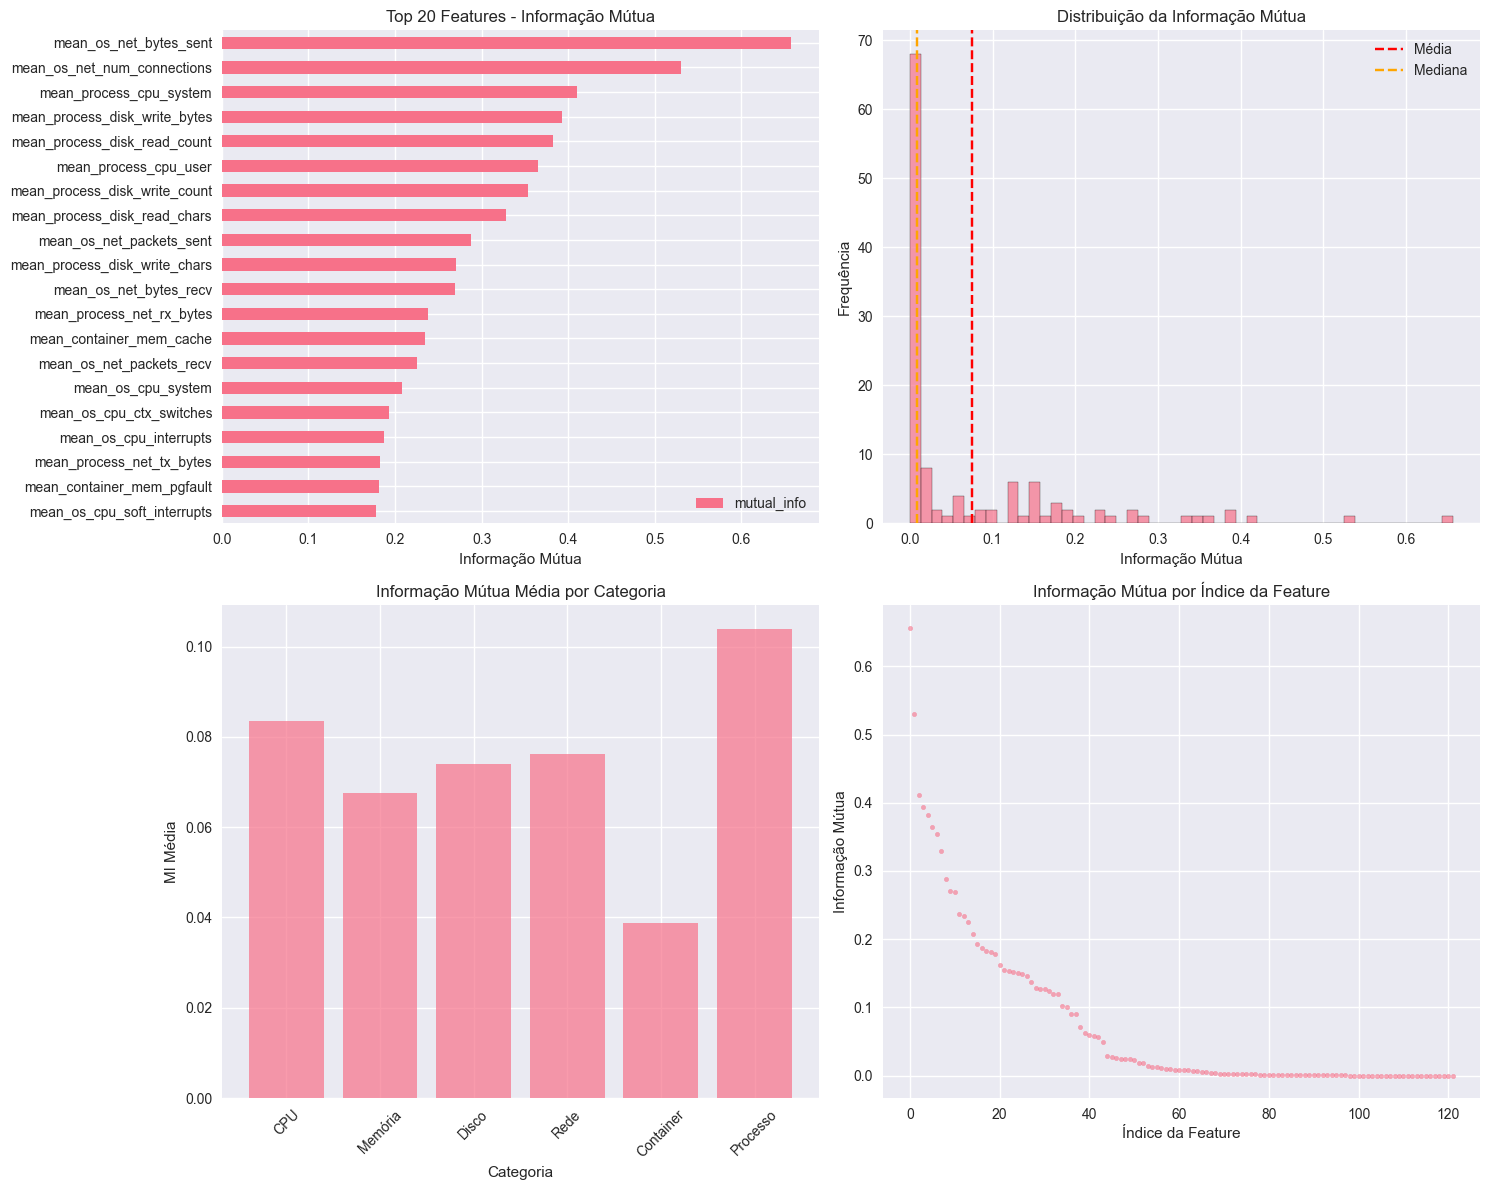

In [26]:
# Análise e visualização dos resultados
if target_column is not None and 'resultados_mi' in locals() and resultados_mi is not None:
    
    print("=== RESULTADOS DO GANHO DE INFORMAÇÃO ===")
    
    # Top 20 features com maior informação mútua
    print("\n🏆 TOP 20 FEATURES - INFORMAÇÃO MÚTUA:")
    top_20_mi = resultados_mi.head(20)
    for i, (_, row) in enumerate(top_20_mi.iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<50} | MI: {row['mutual_info']:.6f}")
    
    # Estatísticas gerais
    print(f"\n📊 ESTATÍSTICAS GERAIS:")
    print(f"• Total de features analisadas: {len(resultados_mi)}")
    print(f"• Informação Mútua média: {resultados_mi['mutual_info'].mean():.6f}")
    print(f"• Informação Mútua mediana: {resultados_mi['mutual_info'].median():.6f}")
    print(f"• Desvio padrão: {resultados_mi['mutual_info'].std():.6f}")
    print(f"• Features com MI > 0.01: {(resultados_mi['mutual_info'] > 0.01).sum()}")
    print(f"• Features com MI > 0.1: {(resultados_mi['mutual_info'] > 0.1).sum()}")
    
    # Visualizações
    plt.figure(figsize=(15, 12))
    
    # 1. Top 20 features
    plt.subplot(2, 2, 1)
    top_20_mi.plot(x='feature', y='mutual_info', kind='barh', ax=plt.gca())
    plt.title('Top 20 Features - Informação Mútua')
    plt.xlabel('Informação Mútua')
    plt.ylabel('')
    plt.gca().invert_yaxis()
    
    # 2. Distribuição dos valores de MI
    plt.subplot(2, 2, 2)
    plt.hist(resultados_mi['mutual_info'], bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(resultados_mi['mutual_info'].mean(), color='red', linestyle='--', label='Média')
    plt.axvline(resultados_mi['mutual_info'].median(), color='orange', linestyle='--', label='Mediana')
    plt.title('Distribuição da Informação Mútua')
    plt.xlabel('Informação Mútua')
    plt.ylabel('Frequência')
    plt.legend()
    
    # 3. Análise por categoria de métrica
    print(f"\n📋 ANÁLISE POR CATEGORIA:")
    
    categorias = {
        'CPU': [col for col in resultados_mi['feature'] if 'cpu' in col.lower()],
        'Memória': [col for col in resultados_mi['feature'] if 'mem' in col.lower()],
        'Disco': [col for col in resultados_mi['feature'] if 'disk' in col.lower()],
        'Rede': [col for col in resultados_mi['feature'] if 'net' in col.lower()],
        'Container': [col for col in resultados_mi['feature'] if 'container' in col.lower()],
        'Processo': [col for col in resultados_mi['feature'] if 'process' in col.lower()]
    }
    
    categoria_scores = {}
    for categoria, features_cat in categorias.items():
        if features_cat:
            scores = resultados_mi[resultados_mi['feature'].isin(features_cat)]['mutual_info']
            categoria_scores[categoria] = {
                'count': len(scores),
                'mean': scores.mean(),
                'max': scores.max(),
                'top_feature': resultados_mi[resultados_mi['feature'].isin(features_cat)].iloc[0]['feature'] if len(scores) > 0 else 'N/A'
            }
            print(f"• {categoria}: {len(scores)} features | Média MI: {scores.mean():.6f} | Max: {scores.max():.6f}")
    
    # 4. MI por categoria
    plt.subplot(2, 2, 3)
    if categoria_scores:
        cats = list(categoria_scores.keys())
        means = [categoria_scores[cat]['mean'] for cat in cats]
        plt.bar(cats, means, alpha=0.7)
        plt.title('Informação Mútua Média por Categoria')
        plt.xlabel('Categoria')
        plt.ylabel('MI Média')
        plt.xticks(rotation=45)
    
    # 5. Scatter plot: MI vs Feature Index
    plt.subplot(2, 2, 4)
    plt.scatter(range(len(resultados_mi)), resultados_mi['mutual_info'], alpha=0.6, s=10)
    plt.title('Informação Mútua por Índice da Feature')
    plt.xlabel('Índice da Feature')
    plt.ylabel('Informação Mútua')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Resultados não disponíveis para visualização")

## 6. Comparação dos Métodos e Feature Selection

=== SELEÇÃO DE FEATURES BASEADA EM GANHO DE INFORMAÇÃO ===

📊 FEATURES SELECIONADAS POR THRESHOLD:
• MI >= 0.001: 84 features (68.9%)
• MI >= 0.005: 67 features (54.9%)
• MI >= 0.01: 58 features (47.5%)
• MI >= 0.02: 51 features (41.8%)
• MI >= 0.05: 43 features (35.2%)
• MI >= 0.1: 35 features (28.7%)

💡 RECOMENDAÇÕES DE THRESHOLD:
• Conservador (Top 25%): MI >= 0.125941
• Agressivo (Top 10%): MI >= 0.233584

🎯 CENÁRIOS DE SELEÇÃO:
• Top 10: MI >= 0.270808
• Top 25: MI >= 0.151108
• Top 50: MI >= 0.024430
• Top 100: MI >= 0.000147

🔍 ANÁLISE DETALHADA DAS TOP 10 FEATURES:
 1. [Rede     ] mean_os_net_bytes_sent                        | MI: 0.656843
 2. [Rede     ] mean_os_net_num_connections                   | MI: 0.530587
 3. [CPU      ] mean_process_cpu_system                       | MI: 0.410629
 4. [Disco    ] mean_process_disk_write_bytes                 | MI: 0.393318
 5. [Disco    ] mean_process_disk_read_count                  | MI: 0.381996
 6. [CPU      ] mean_process_cpu_us

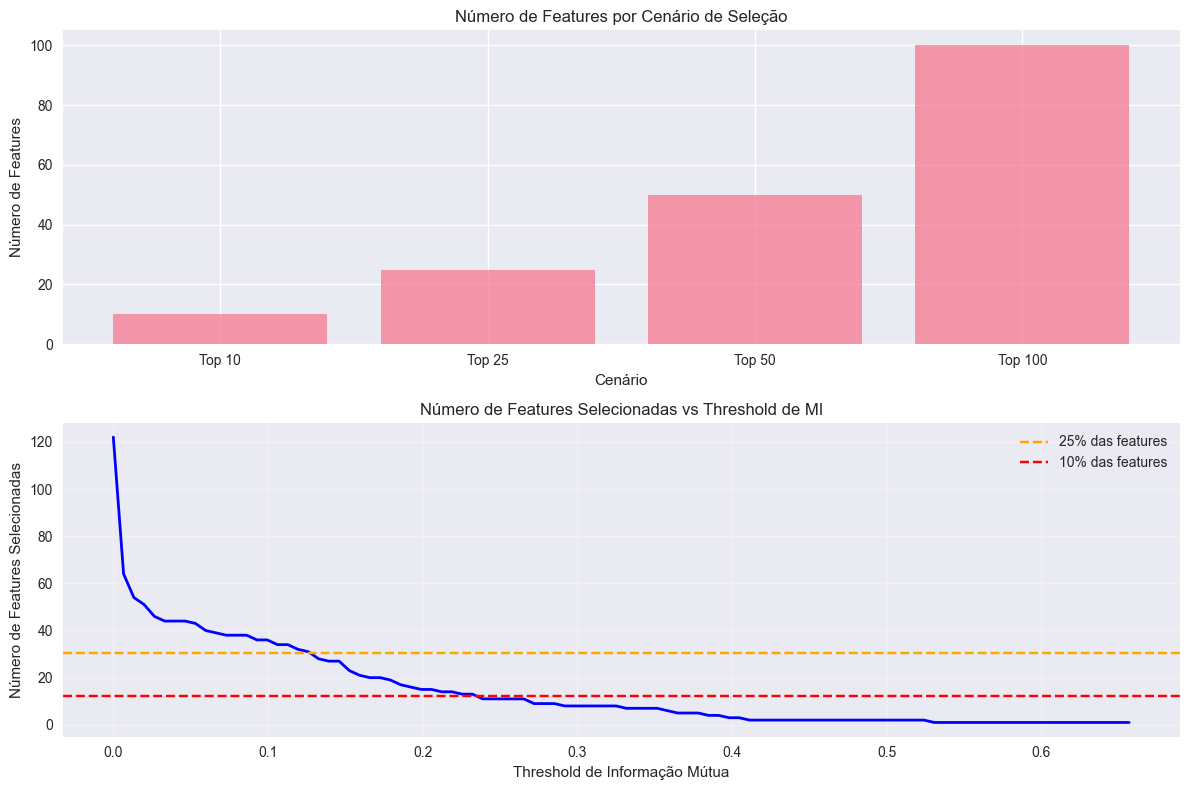

In [20]:
# Comparação entre métodos e seleção de features
if target_column is not None and 'resultados_mi' in locals() and resultados_mi is not None:
    
    print("=== SELEÇÃO DE FEATURES BASEADA EM GANHO DE INFORMAÇÃO ===")
    
    # Definir diferentes thresholds para seleção de features
    thresholds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]
    
    print(f"\n📊 FEATURES SELECIONADAS POR THRESHOLD:")
    for threshold in thresholds:
        selected = resultados_mi[resultados_mi['mutual_info'] >= threshold]
        print(f"• MI >= {threshold}: {len(selected)} features ({len(selected)/len(resultados_mi)*100:.1f}%)")
    
    # Recomendar threshold baseado na distribuição
    q75 = resultados_mi['mutual_info'].quantile(0.75)
    q90 = resultados_mi['mutual_info'].quantile(0.90)
    
    print(f"\n💡 RECOMENDAÇÕES DE THRESHOLD:")
    print(f"• Conservador (Top 25%): MI >= {q75:.6f}")
    print(f"• Agressivo (Top 10%): MI >= {q90:.6f}")
    
    # Selecionar top features para diferentes cenários
    scenarios = {
        'Top 10': 10,
        'Top 25': 25,
        'Top 50': 50,
        'Top 100': 100
    }
    
    print(f"\n🎯 CENÁRIOS DE SELEÇÃO:")
    selected_features = {}
    
    for scenario_name, n_features in scenarios.items():
        if n_features <= len(resultados_mi):
            top_features = resultados_mi.head(n_features)['feature'].tolist()
            selected_features[scenario_name] = top_features
            mi_min = resultados_mi.iloc[n_features-1]['mutual_info']
            print(f"• {scenario_name}: MI >= {mi_min:.6f}")
    
    # Análise da importância por tipo de métrica
    print(f"\n🔍 ANÁLISE DETALHADA DAS TOP 10 FEATURES:")
    top_10 = resultados_mi.head(10)
    
    for i, (_, row) in enumerate(top_10.iterrows(), 1):
        feature_name = row['feature']
        mi_score = row['mutual_info']
        
        # Identificar tipo de métrica
        if 'cpu' in feature_name.lower():
            tipo = 'CPU'
        elif 'mem' in feature_name.lower():
            tipo = 'Memória'
        elif 'disk' in feature_name.lower():
            tipo = 'Disco'
        elif 'net' in feature_name.lower():
            tipo = 'Rede'
        elif 'container' in feature_name.lower():
            tipo = 'Container'
        elif 'process' in feature_name.lower():
            tipo = 'Processo'
        else:
            tipo = 'Outro'
        
        print(f"{i:2d}. [{tipo:9s}] {feature_name:<45} | MI: {mi_score:.6f}")
    
    # Salvar resultados em CSV
    print(f"\n💾 SALVANDO RESULTADOS...")
    
    # Salvar ranking completo
    resultados_mi.to_csv('information_gain_ranking.csv', index=False)
    print("• Ranking completo salvo em: information_gain_ranking.csv")
    
    # Salvar diferentes seleções de features
    for scenario_name, features_list in selected_features.items():
        filename = f'selected_features_{scenario_name.lower().replace(" ", "_")}.txt'
        with open(filename, 'w') as f:
            for feature in features_list:
                f.write(f"{feature}\n")
        print(f"• {scenario_name} features salvas em: {filename}")
    
    # Estatísticas finais
    print(f"\n📈 RESUMO EXECUTIVO:")
    print(f"• Total de features analisadas: {len(resultados_mi)}")
    print(f"• Feature mais informativa: {resultados_mi.iloc[0]['feature']} (MI: {resultados_mi.iloc[0]['mutual_info']:.6f})")
    print(f"• Entropia do target: {calcular_entropia(y_encoded):.6f}")
    print(f"• Features com MI > 0: {(resultados_mi['mutual_info'] > 0).sum()}")
    
    # Visualizar comparação de cenários
    plt.figure(figsize=(12, 8))
    
    # Gráfico de barras dos cenários
    plt.subplot(2, 1, 1)
    scenario_names = list(scenarios.keys())
    scenario_counts = [scenarios[name] for name in scenario_names if scenarios[name] <= len(resultados_mi)]
    scenario_names_valid = [name for name in scenario_names if scenarios[name] <= len(resultados_mi)]
    
    plt.bar(scenario_names_valid, scenario_counts, alpha=0.7)
    plt.title('Número de Features por Cenário de Seleção')
    plt.xlabel('Cenário')
    plt.ylabel('Número de Features')
    
    # Gráfico do threshold vs número de features
    plt.subplot(2, 1, 2)
    threshold_range = np.linspace(0, resultados_mi['mutual_info'].max(), 100)
    n_features_selected = [len(resultados_mi[resultados_mi['mutual_info'] >= t]) for t in threshold_range]
    
    plt.plot(threshold_range, n_features_selected, 'b-', linewidth=2)
    plt.axhline(y=len(resultados_mi)*0.25, color='orange', linestyle='--', label='25% das features')
    plt.axhline(y=len(resultados_mi)*0.10, color='red', linestyle='--', label='10% das features')
    plt.title('Número de Features Selecionadas vs Threshold de MI')
    plt.xlabel('Threshold de Informação Mútua')
    plt.ylabel('Número de Features Selecionadas')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("❌ Não é possível realizar comparação sem resultados válidos")

## 7. Análise de Correlação entre MI e Outras Métricas

In [ ]:
# Análise adicional: correlação entre MI e características das features
if target_column is not None and 'resultados_mi' in locals() and resultados_mi is not None:
    
    print("=== ANÁLISE CORRELACIONAL AVANÇADA ===")
    
    # Calcular estatísticas das features para correlacionar com MI
    feature_stats = []
    
    for feature in resultados_mi['feature']:
        if feature in X.columns:
            values = X[feature].dropna()
            if len(values) > 0:
                stats = {
                    'feature': feature,
                    'mean': values.mean(),
                    'std': values.std(),
                    'min': values.min(),
                    'max': values.max(),
                    'range': values.max() - values.min(),
                    'skewness': values.skew(),
                    'kurtosis': values.kurtosis(),
                    'unique_values': values.nunique(),
                    'zeros_pct': (values == 0).mean() * 100
                }
                feature_stats.append(stats)
    
    df_stats = pd.DataFrame(feature_stats)
    
    # Merge com resultados de MI
    analysis_df = resultados_mi.merge(df_stats, on='feature')
    
    print(f"\n🔍 CORRELAÇÕES ENTRE MI E CARACTERÍSTICAS DAS FEATURES:")
    
    correlations = {}
    stat_columns = ['std', 'range', 'skewness', 'kurtosis', 'unique_values', 'zeros_pct']
    
    for stat_col in stat_columns:
        if stat_col in analysis_df.columns:
            corr = analysis_df['mutual_info'].corr(analysis_df[stat_col])
            correlations[stat_col] = corr
            print(f"• MI vs {stat_col:15s}: {corr:7.4f}")
    
    # Visualizar correlações
    plt.figure(figsize=(15, 12))
    
    # 1. Scatter plots das correlações mais interessantes
    interesting_stats = ['std', 'unique_values', 'zeros_pct', 'range']
    
    for i, stat in enumerate(interesting_stats, 1):
        if stat in analysis_df.columns:
            plt.subplot(2, 2, i)
            plt.scatter(analysis_df[stat], analysis_df['mutual_info'], alpha=0.6)
            plt.xlabel(stat.replace('_', ' ').title())
            plt.ylabel('Informação Mútua')
            plt.title(f'MI vs {stat.replace("_", " ").title()}\nCorrelação: {correlations.get(stat, 0):.4f}')
            
            # Adicionar linha de tendência
            z = np.polyfit(analysis_df[stat], analysis_df['mutual_info'], 1)
            p = np.poly1d(z)
            plt.plot(analysis_df[stat], p(analysis_df[stat]), "r--", alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Análise de features com alta MI
    print(f"\n🎯 CARACTERÍSTICAS DAS FEATURES COM ALTA MI (Top 10):")
    top_10_analysis = analysis_df.head(10)
    
    print("Feature                                      | MI      | Std Dev | Unique Val | Zeros%")
    print("-" * 85)
    for _, row in top_10_analysis.iterrows():
        print(f"{row['feature'][:40]:40} | {row['mutual_info']:.5f} | {row['std']:.2e} | {row['unique_values']:8} | {row['zeros_pct']:5.1f}%")
    
    # Análise por faixas de MI
    print(f"\n📊 ANÁLISE POR FAIXAS DE INFORMAÇÃO MÚTUA:")
    
    # Dividir em quartis
    quartis = analysis_df['mutual_info'].quantile([0.25, 0.5, 0.75]).values
    
    faixas = {
        'Baixa (Q1)': analysis_df[analysis_df['mutual_info'] <= quartis[0]],
        'Média-Baixa (Q2)': analysis_df[(analysis_df['mutual_info'] > quartis[0]) & (analysis_df['mutual_info'] <= quartis[1])],
        'Média-Alta (Q3)': analysis_df[(analysis_df['mutual_info'] > quartis[1]) & (analysis_df['mutual_info'] <= quartis[2])],
        'Alta (Q4)': analysis_df[analysis_df['mutual_info'] > quartis[2]]
    }
    
    for faixa_name, faixa_data in faixas.items():
        if len(faixa_data) > 0:
            print(f"\n{faixa_name} ({len(faixa_data)} features):")
            print(f"  • MI médio: {faixa_data['mutual_info'].mean():.6f}")
            print(f"  • Std Dev médio: {faixa_data['std'].mean():.2e}")
            print(f"  • Valores únicos médios: {faixa_data['unique_values'].mean():.1f}")
            print(f"  • % zeros médio: {faixa_data['zeros_pct'].mean():.1f}%")
    
    # Identificar padrões nas features mais importantes
    print(f"\n🔍 PADRÕES NAS FEATURES MAIS IMPORTANTES:")
    
    # Análise das palavras-chave nas top features
    top_features = resultados_mi.head(20)['feature'].tolist()
    
    keywords = ['cpu', 'mem', 'disk', 'net', 'container', 'process', 'mean', 'nr', 'bytes']
    keyword_counts = {}
    
    for keyword in keywords:
        count = sum(1 for feature in top_features if keyword in feature.lower())
        if count > 0:
            keyword_counts[keyword] = count
    
    print("Palavras-chave mais frequentes nas Top 20 features:")
    for keyword, count in sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  • '{keyword}': {count} ocorrências ({count/20*100:.1f}%)")
    
else:
    print("❌ Análise correlacional não disponível")

## 8. Relatório Final e Recomendações

In [ ]:
# Relatório final sobre ganho de informação
if target_column is not None and 'resultados_mi' in locals() and resultados_mi is not None:
    
    print("="*80)
    print("                    RELATÓRIO FINAL - GANHO DE INFORMAÇÃO")
    print("                           Dataset SVM - KubeMon")
    print("="*80)
    
    print(f"\n📊 RESUMO EXECUTIVO:")
    print(f"   • Dataset analisado: {df.shape[0]:,} registros x {df.shape[1]} colunas")
    print(f"   • Features numéricas analisadas: {len(features)}")
    print(f"   • Variável target: '{target_column}' com {len(np.unique(y_encoded))} classes")
    print(f"   • Entropia do target: {calcular_entropia(y_encoded):.4f} bits")
    
    # Top features
    print(f"\n🏆 TOP 10 FEATURES MAIS INFORMATIVAS:")
    for i, (_, row) in enumerate(resultados_mi.head(10).iterrows(), 1):
        # Identificar categoria
        feature_name = row['feature']
        if 'cpu' in feature_name.lower():
            categoria = '[CPU]'
        elif 'mem' in feature_name.lower():
            categoria = '[MEM]'
        elif 'disk' in feature_name.lower():
            categoria = '[DSK]'
        elif 'net' in feature_name.lower():
            categoria = '[NET]'
        elif 'container' in feature_name.lower():
            categoria = '[CTR]'
        else:
            categoria = '[OTR]'
        
        print(f"   {i:2d}. {categoria} {feature_name[:55]:<55} | MI: {row['mutual_info']:.6f}")
    
    # Análise por categoria
    print(f"\n📋 DISTRIBUIÇÃO POR CATEGORIA DE MÉTRICA:")
    if 'categoria_scores' in locals():
        for categoria, info in categoria_scores.items():
            print(f"   • {categoria:12s}: {info['count']:3d} features | Média MI: {info['mean']:.6f} | Melhor: {info['top_feature'][:40]}")
    
    # Estatísticas de distribuição
    print(f"\n📈 ESTATÍSTICAS DA INFORMAÇÃO MÚTUA:")
    stats = resultados_mi['mutual_info'].describe()
    print(f"   • Mínimo:    {stats['min']:.6f}")
    print(f"   • 25º perc:  {stats['25%']:.6f}")
    print(f"   • Mediana:   {stats['50%']:.6f}")
    print(f"   • Média:     {stats['mean']:.6f}")
    print(f"   • 75º perc:  {stats['75%']:.6f}")
    print(f"   • Máximo:    {stats['max']:.6f}")
    print(f"   • Desvio:    {stats['std']:.6f}")
    
    # Thresholds recomendados
    q75 = resultados_mi['mutual_info'].quantile(0.75)
    q90 = resultados_mi['mutual_info'].quantile(0.90)
    q95 = resultados_mi['mutual_info'].quantile(0.95)
    
    print(f"\n🎯 RECOMENDAÇÕES DE SELEÇÃO DE FEATURES:")
    print(f"   • Feature Selection Conservadora (Top 25%): MI >= {q75:.6f} → {(resultados_mi['mutual_info'] >= q75).sum()} features")
    print(f"   • Feature Selection Balanceada (Top 10%):   MI >= {q90:.6f} → {(resultados_mi['mutual_info'] >= q90).sum()} features")
    print(f"   • Feature Selection Agressiva (Top 5%):    MI >= {q95:.6f} → {(resultados_mi['mutual_info'] >= q95).sum()} features")
    
    # Identificar features com MI zero ou muito baixo
    low_mi = resultados_mi[resultados_mi['mutual_info'] < 0.001]
    zero_mi = resultados_mi[resultados_mi['mutual_info'] == 0]
    
    print(f"\n⚠️  FEATURES COM BAIXO PODER DISCRIMINATIVO:")
    print(f"   • Features com MI = 0:     {len(zero_mi)} ({len(zero_mi)/len(resultados_mi)*100:.1f}%)")
    print(f"   • Features com MI < 0.001: {len(low_mi)} ({len(low_mi)/len(resultados_mi)*100:.1f}%)")
    
    if len(zero_mi) > 0:
        print(f"   • Considere remover features com MI = 0 (não contribuem para classificação)")
    
    # Análise de padrões
    print(f"\n🔍 INSIGHTS E PADRÕES IDENTIFICADOS:")
    
    # Feature com maior MI
    best_feature = resultados_mi.iloc[0]
    print(f"   • Feature mais informativa: '{best_feature['feature']}' (MI: {best_feature['mutual_info']:.6f})")
    
    # Análise de correlações com características
    if 'correlations' in locals():
        strongest_corr = max(correlations.items(), key=lambda x: abs(x[1]))
        print(f"   • MI tem maior correlação com: {strongest_corr[0]} (r = {strongest_corr[1]:.4f})")
    
    # Features que podem ser redundantes (alta correlação entre si)
    print(f"   • Para redução adicional, analise correlações entre as top features")
    print(f"   • Considere técnicas de regularização (L1/L2) no modelo SVM")
    
    print(f"\n💡 PRÓXIMOS PASSOS RECOMENDADOS:")
    print(f"   1. Aplicar feature selection usando thresholds sugeridos")
    print(f"   2. Validar seleção com validação cruzada no modelo SVM")
    print(f"   3. Comparar desempenho: All features vs Selected features")
    print(f"   4. Considerar ensemble de diferentes seleções de features")
    print(f"   5. Analisar feature importance no modelo treinado")
    print(f"   6. Implementar pipeline de pré-processamento com feature selection")
    
    print(f"\n📁 ARQUIVOS GERADOS:")
    print(f"   • information_gain_ranking.csv - Ranking completo de features")
    print(f"   • selected_features_*.txt - Listas de features selecionadas")
    
    print(f"\n" + "="*80)
    print("                           ANÁLISE CONCLUÍDA! 🎉")
    print("="*80)
    
    # Criar resumo final em formato de tabela
    summary_data = {
        'Métrica': ['Total Features', 'Features Analisadas', 'MI Máximo', 'MI Médio', 'Features MI > 0.01', 'Features Recomendadas (Top 10%)'],
        'Valor': [
            df.shape[1],
            len(features),
            f"{resultados_mi['mutual_info'].max():.6f}",
            f"{resultados_mi['mutual_info'].mean():.6f}",
            (resultados_mi['mutual_info'] > 0.01).sum(),
            (resultados_mi['mutual_info'] >= q90).sum()
        ]
    }
    
    summary_df = pd.DataFrame(summary_data)
    print(f"\n📋 RESUMO QUANTITATIVO:")
    print(summary_df.to_string(index=False))
    
else:
    print("❌ Não foi possível gerar o relatório final")